In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle
from time_series_split import *

In [38]:
def calculate_aqi(pm25):
    ranges = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.0, 301, 500),
    ]
    for c_low, c_high, aqi_low, aqi_high in ranges:
        if c_low <= pm25 <= c_high:
            return round((aqi_high - aqi_low) / (c_high - c_low) * (pm25 - c_low) + aqi_low)
    return 500  # default nếu vượt ngưỡng

def aqi_class(aqi):
    if aqi <= 50: return 0
    elif aqi <= 100: return 1
    elif aqi <= 150: return 2
    elif aqi <= 200: return 3
    elif aqi <= 300: return 4
    else: return 5

In [39]:
combined_data = pd.read_csv('/home/thu/INT3041E_AI_PM2.5-Concentration-Estimation/data/consolidation/remotesensing_atmospheric.csv')
combined_data.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,RH,PRES2M,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,...,74.750000,102197.203125,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,...,74.750000,102197.203125,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,...,73.687500,102228.796875,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,...,74.750000,102197.203125,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,...,78.012497,102025.328125,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681


In [40]:
# Tính cột AQI từ PM2.5
combined_data['AQI'] = combined_data['pm25'].apply(calculate_aqi)
# Gán nhãn lớp AQI
combined_data['AQI_Class'] = combined_data['AQI'].apply(aqi_class)

In [41]:
combined_data.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI,AQI,AQI_Class
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,...,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203,183,3
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,...,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537,177,3
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,...,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304,183,3
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,...,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613,183,3
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,...,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681,162,3


In [7]:
# combined_data.to_csv("/home/thu/INT3041E_AI_PM2.5-Concentration-Estimation/data/add_AQI.csv", index=False)

In [42]:
# folds = split_original_data()
folds = split_consolidated_data()
print(f"Number of folds: {len(folds)}")

Number of folds: 3


In [43]:
fold = folds[0]
train_data = fold['train']
val_data = fold['validation']
test_data = fold['test']

In [17]:
# Chuẩn bị features và target từ các DataFrame
# Features: Loại trừ pm25, AQI, AQI_Class (tương tự cột 2 đến -2 trong combined_data)
feature_columns = train_data.columns[2:-2]  # Từ cột 2 (lat) đến cột -2 (AAI)

X_train = train_data[feature_columns]
y_train = train_data['AQI_Class']

X_val = val_data[feature_columns]
y_val = val_data['AQI_Class']

X_test = test_data[feature_columns]
y_test = test_data['AQI_Class']

In [18]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10193, 20), y_train shape: (10193,)
X_val shape: (366, 20), y_val shape: (366,)
X_test shape: (327, 20), y_test shape: (327,)


**Best paramters**

In [29]:
params = {
    'n_estimators': 100,
    'max_features': 'log2',
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

In [ ]:
clf = RandomForestClassifier(
    n_estimators=params['n_estimators'],
    max_features=params['max_features'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf'],
    random_state=43
)

clf.fit(X_train, y_train)

In [33]:
val_accuracy = clf.score(X_val, y_val)
print(f"Accuracy on validation set: {val_accuracy:.4f}")

Accuracy on validation set: 0.9699


In [34]:
test_accuracy = clf.score(X_test, y_test)
print(f"Accuracy on test set: {test_accuracy:.4f}")

Accuracy on test set: 0.8165


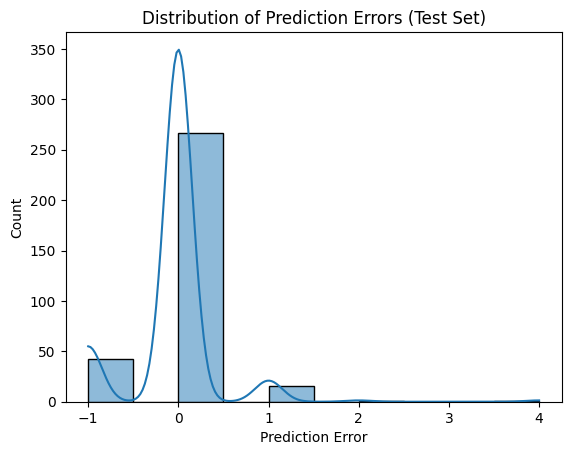

In [35]:
pred = clf.predict(X_test)
sns.histplot(y_test - pred, kde=True)
plt.title('Distribution of Prediction Errors (Test Set)')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

In [ ]:
print(f"Classification Report (Test Set):\n{metrics.classification_report(y_test, pred, zero_division=1)}")

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.65      0.79       120
           1       0.73      1.00      0.84       117
           2       0.76      1.00      0.86        51
           3       1.00      0.55      0.71        38
           5       1.00      0.00      0.00         1

    accuracy                           0.82       327
   macro avg       0.90      0.64      0.64       327
weighted avg       0.86      0.82      0.81       327



In [37]:
pickle.dump(clf, open('randomforest-classifier.pkl', 'wb'))